In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import scipy.stats as stats
warnings.filterwarnings('ignore')

# Loading

In [46]:
weeks = [f"Quiz #{i}" for i in range (1, 12)]

In [47]:
df_load = pd.read_json('merged_logs.jsonl', lines=True, convert_dates=['_creationTime'])

In [48]:
df  = df_load.copy()
weeks = [f"Quiz #{i}" for i in range (1, 12)]
invalid_exs = ["k173an7ns7g76j493paexdh88d6n3bsh","k17aatn2xs5xgqg6cgcjm1tqcn6q0cw7"]
invalid_weeks = ["Quiz #3","Quiz #6"]
df = df[~df['exerciseId'].isin(invalid_exs)]
if True :
    df = df[df['valid']]
df = df.drop_duplicates(subset=['_id'])
before = len(df)
mt=0.25
df["timeSpent_quiz"]=df["timeSpent_quiz"].apply(np.log1p)
df["timeSpent_read"]=df["timeSpent_read"].apply(np.log1p)
df["timeSpent_message"]=df["timeSpent_message"].apply(np.log1p)

# Attempts Analysis

week
Quiz #1     1567
Quiz #2     3178
Quiz #3     2083
Quiz #4     2611
Quiz #5     4484
Quiz #6     2063
Quiz #7     2481
Quiz #8     4293
Quiz #9     1815
Quiz #10    2224
Quiz #11    4013
Name: count, dtype: int64


0          NaN
1          9.0
2          7.0
3         53.0
4          NaN
          ... 
150887     NaN
150888     NaN
150890     NaN
150892     NaN
150894     NaN
Name: num_attempts, Length: 115382, dtype: float64

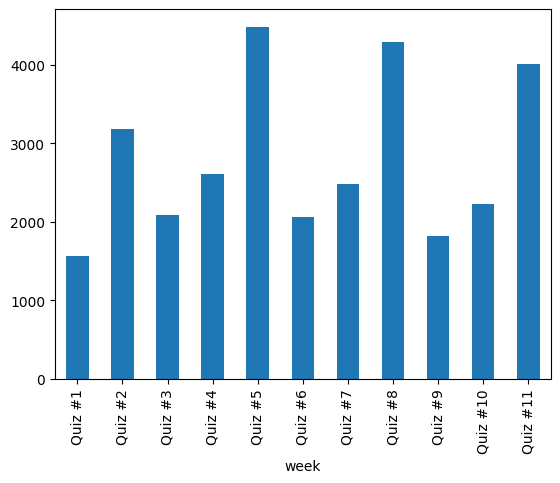

In [49]:
print(df.query("type == 'quizSubmission'")["week"].value_counts()[weeks])
df.query("type == 'quizSubmission'")["week"].value_counts()[weeks].plot(kind='bar')
df["num_attempts"] = df[df['type'] == 'quizSubmission'].groupby(["userId", "exerciseId"])["type"].transform('count')
display(df["num_attempts"] )
plt.savefig('figures/attempts/attemptStarted.png')
plt.show()



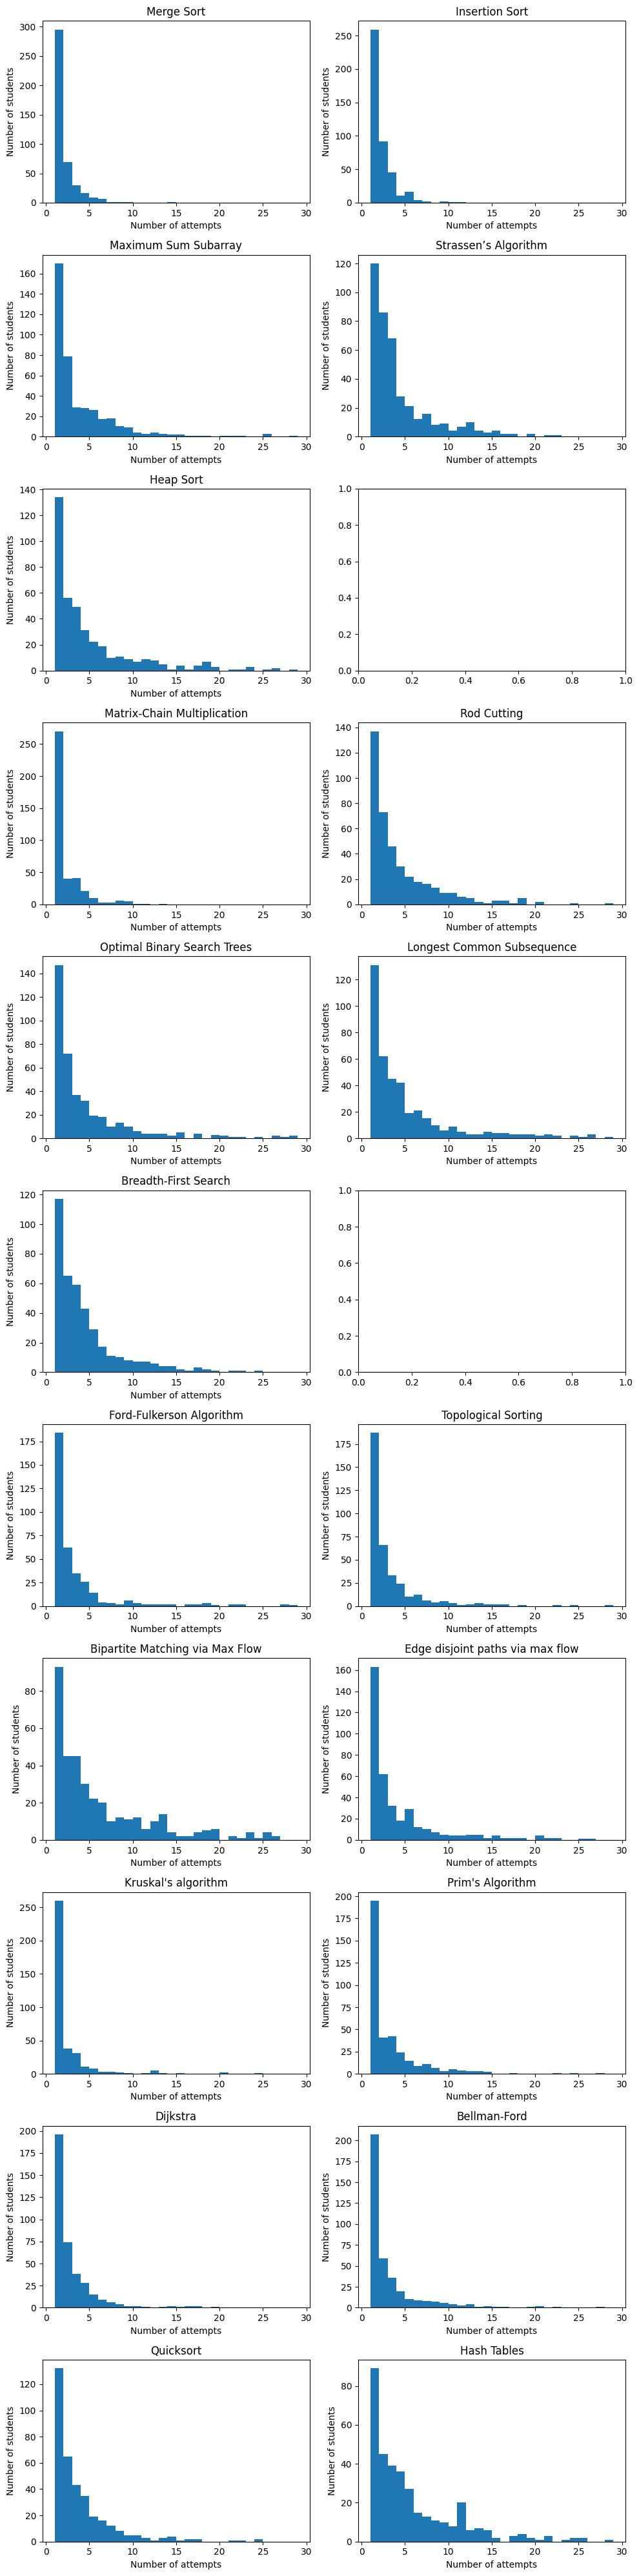

In [50]:
fig, ax = plt.subplots(11, 2, figsize=(10, 40))
bins = np.arange(1, 30,1)
for i,week in enumerate(weeks):
    attempts = df.query("week == @week")
    for j,ex in enumerate(attempts["exerciseName"].unique()):
        q = attempts.query("exerciseName == @ex and type == 'quizSubmission'").drop_duplicates(subset=['userId', 'exerciseId'])["num_attempts"]
        q.plot(kind='hist', bins=bins, ax=ax[i,j])
        ax[i,j].set_xlabel("Number of attempts")
        ax[i,j].set_ylabel("Number of students")
        ax[i,j].set_title(ex)

plt.tight_layout()
plt.savefig('figures/attempts/number_of_attempts.png')
plt.show()

## Number of Attempts

3.810617662072486 4.019741837509491 0.16412822855188902
14930.0 15882.0


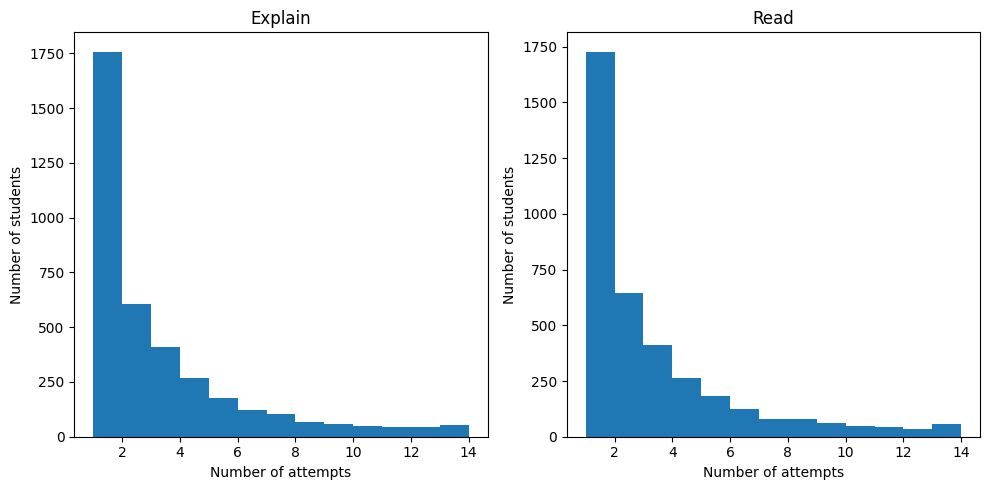

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
bins = np.arange(1, 15,1)
explain = df.query("variant == 'explain'").dropna(subset="num_attempts").drop_duplicates(subset=["userId","exerciseName"])["num_attempts"]
explain.plot(kind='hist', ax=ax[0], title='Explain', bins=bins)
ax[0].set_xlabel("Number of attempts")
ax[0].set_ylabel("Number of students")
ax[0].set_title("Explain")
read = df.query("variant == 'reading'").dropna(subset="num_attempts").drop_duplicates(subset=["userId","exerciseName"])["num_attempts"].dropna()
read.plot(kind='hist', ax=ax[1], title='Read', bins=bins)
ax[1].set_xlabel("Number of attempts")
ax[1].set_ylabel("Number of students")
ax[1].set_title("Read")
plt.tight_layout()
ttest = stats.ttest_ind(explain, read)
print(explain.mean(),read.mean(),ttest.pvalue)
print(explain.sum(),read.sum())


Merge Sort: Explain mean: 2.04, Reading mean: 1.60, p-value: 0.22
Insertion Sort: Explain mean: 1.68, Reading mean: 1.91, p-value: 0.08
Maximum Sum Subarray: Explain mean: 3.27, Reading mean: 3.91, p-value: 0.11
Strassen’s Algorithm: Explain mean: 4.09, Reading mean: 4.17, p-value: 0.87
Heap Sort: Explain mean: 5.14, Reading mean: 5.15, p-value: 0.99
Rod Cutting: Explain mean: 4.21, Reading mean: 4.89, p-value: 0.57
Matrix-Chain Multiplication: Explain mean: 1.80, Reading mean: 2.04, p-value: 0.18
Optimal Binary Search Trees: Explain mean: 4.69, Reading mean: 5.56, p-value: 0.25
Longest Common Subsequence: Explain mean: 5.36, Reading mean: 6.03, p-value: 0.43
Breadth-First Search: Explain mean: 5.37, Reading mean: 4.67, p-value: 0.30
Topological Sorting: Explain mean: 2.93, Reading mean: 3.13, p-value: 0.66
Ford-Fulkerson Algorithm: Explain mean: 2.94, Reading mean: 4.50, p-value: 0.04
Bipartite Matching via Max Flow: Explain mean: 6.63, Reading mean: 7.73, p-value: 0.23
Edge disjoint 

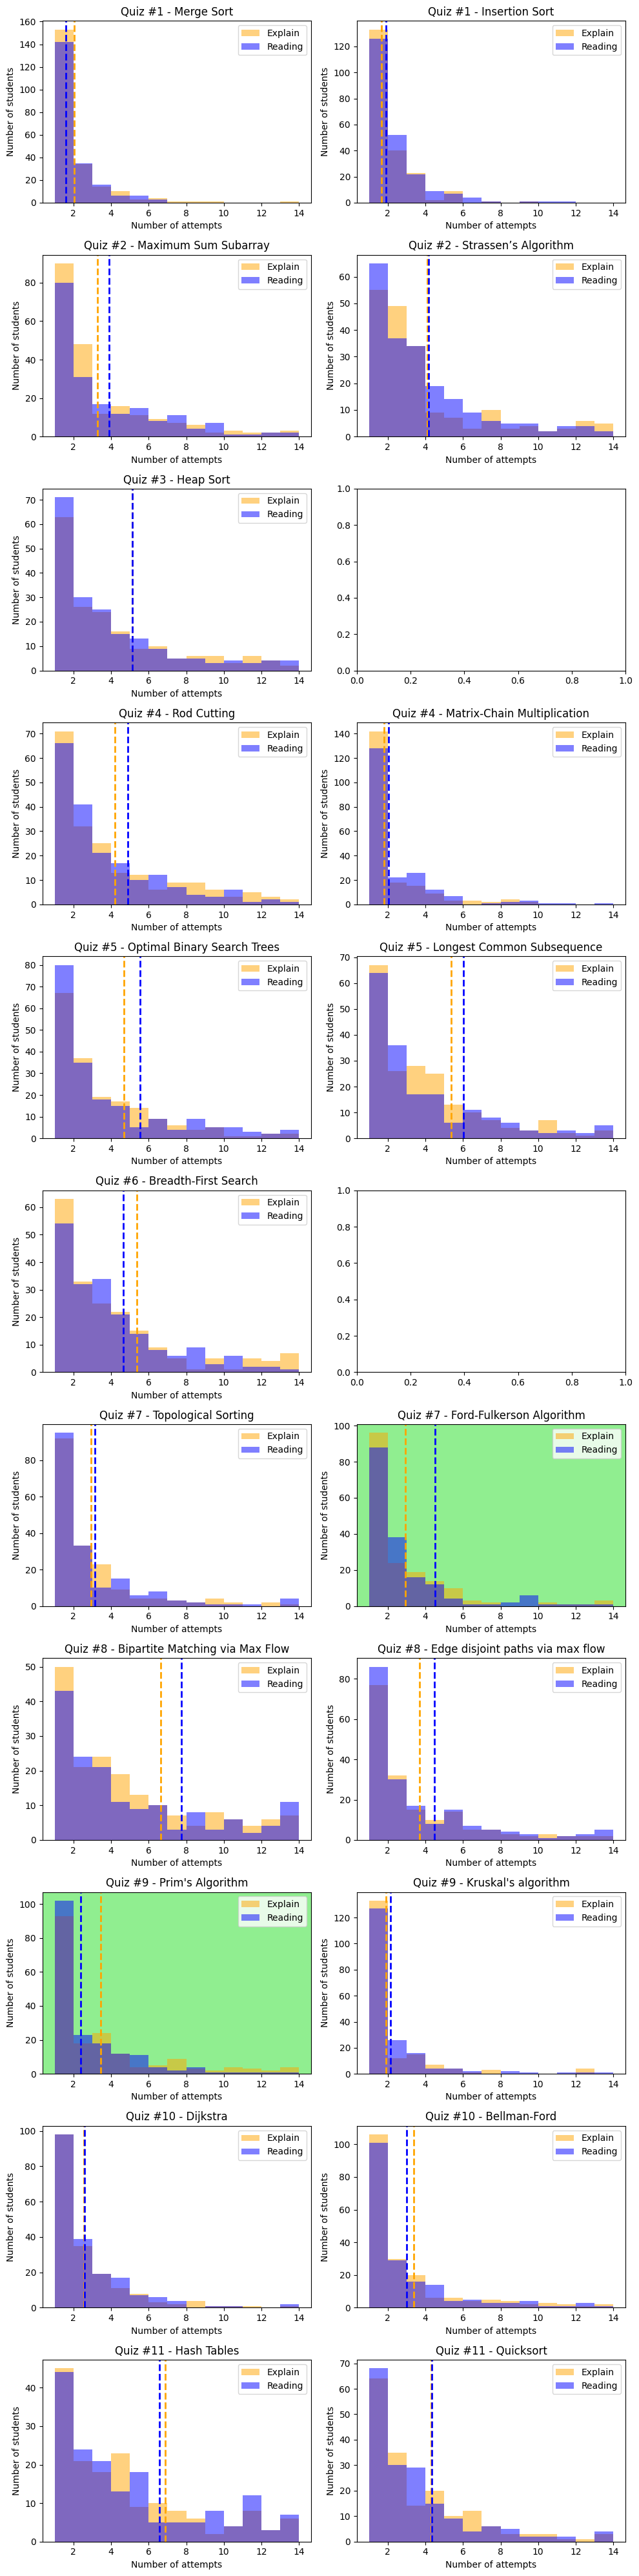

In [52]:
fig, ax = plt.subplots(len(weeks), 2, figsize=(10, 40))
bins = np.arange(1, 15, 1)

for week in weeks:
    explain = df.query("variant == 'explain' and week == @week").dropna(subset="num_attempts").drop_duplicates(subset=['userId', 'exerciseId'])
    read = df.query("variant == 'reading' and week == @week").dropna(subset="num_attempts").drop_duplicates(subset=['userId', 'exerciseId'])
    exercise_list = list(explain["exerciseName"].unique())

    for ex in exercise_list:
        idx = exercise_list.index(ex)          
        dfe = explain.query("exerciseName == @ex")["num_attempts"]
        dfr = read.query("exerciseName == @ex")["num_attempts"]        
        dfe.plot(kind='hist', ax=ax[weeks.index(week), idx], bins=bins, alpha=0.5, label='Explain', color='orange')
        dfr.plot(kind='hist', ax=ax[weeks.index(week), idx], bins=bins, alpha=0.5, label='Reading', color='blue')
        ax[weeks.index(week), idx].set_xlabel("Number of attempts")
        ax[weeks.index(week), idx].set_ylabel("Number of students")
        ax[weeks.index(week), idx].set_title(f"{week} - {ex}")        
        ax[weeks.index(week), idx].axvline(dfe.mean(), color='orange', linestyle='dashed', linewidth=2)
        ax[weeks.index(week), idx].axvline(dfr.mean(), color='blue', linestyle='dashed', linewidth=2)
        ttest = stats.ttest_ind(dfe, dfr)        
        if ttest.pvalue < 0.05:
            ax[weeks.index(week), idx].set_facecolor('lightgreen')        
        print(f"{ex}: Explain mean: {dfe.mean():.2f}, Reading mean: {dfr.mean():.2f}, p-value: {ttest.pvalue:.2f}")
        ax[weeks.index(week), idx].legend()

plt.tight_layout()


## Number of Completed Exercises

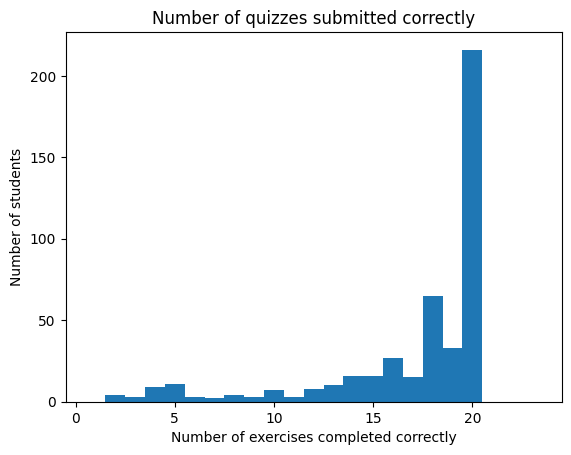

In [53]:
df[(df["type"]=="quizSubmission") & (df["details"].apply(
    lambda x: x.get("correctness")==1 if x is not None else False))]["userId"].value_counts().plot(
        kind='hist', bins=np.arange(1,25, 1))
plt.xticks(np.arange(1,25,5)-0.5, np.arange(0,25,5))
plt.xlabel("Number of exercises completed correctly")
plt.ylabel("Number of students")
plt.title("Number of quizzes submitted correctly")
plt.xlim(0,25)
plt.savefig('figures/attempts/number_of_quizzes.png')
plt.show()


# Quiz Time Analysis

count    7794.000000
mean        2.162473
std         1.529173
min         0.019066
25%         1.221893
50%         1.861618
75%         2.657578
max         9.762292
Name: timeSpent_quiz, dtype: float64


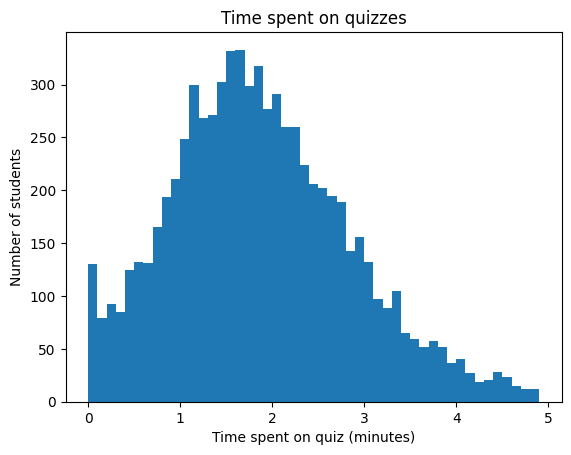

In [54]:
ts_df =df.dropna(subset=["timeSpent_quiz"]).drop_duplicates(subset=["userId", "exerciseName"])
ts = ts_df["timeSpent_quiz"]
print(ts.describe())
ts.plot(kind='hist', bins=np.arange(0, 5, .1))
plt.xlabel("Time spent on quiz (minutes)")
plt.ylabel("Number of students")
plt.title("Time spent on quizzes")
plt.savefig('figures/quiz/time_spent.png')
plt.show()


## Explain vs Read

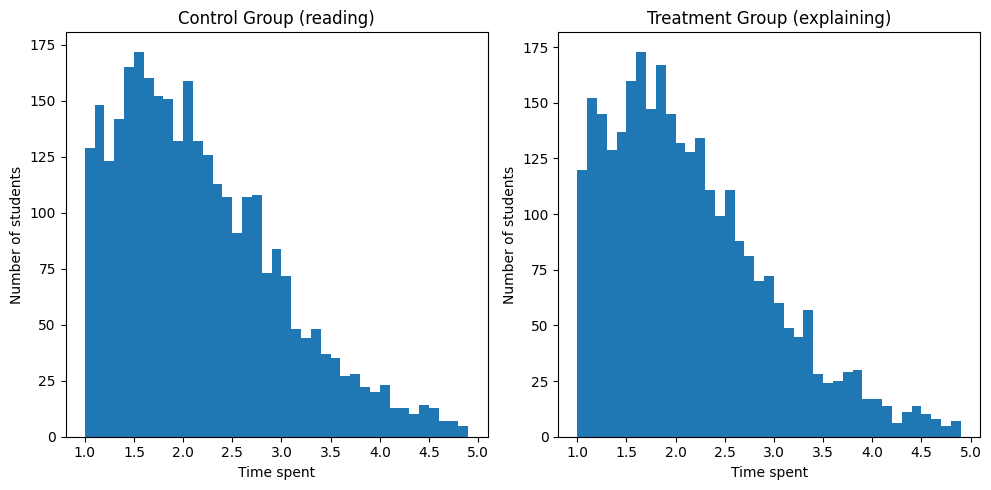

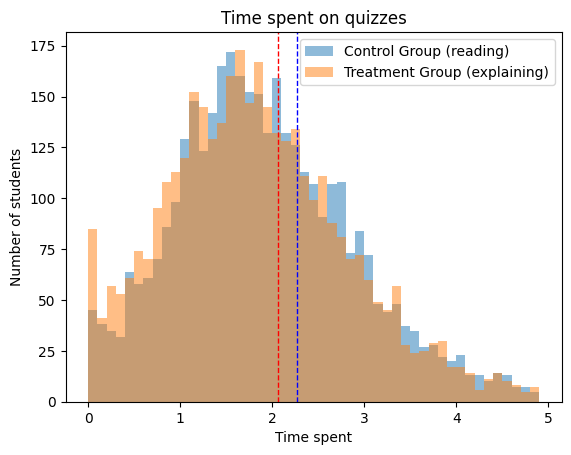

Reading group: 2.265635187054938
Explaining group: 2.058833947906804
TtestResult(statistic=np.float64(5.984570702038305), pvalue=np.float64(2.2669068427925716e-09), df=np.float64(7690.23197645736))


In [55]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
reading = df[df["variant"] == "reading"].dropna(subset=["timeSpent_quiz"]).drop_duplicates(subset=["userId", "exerciseName"])
explaining = df[df["variant"] == "explain"].dropna(subset=["timeSpent_quiz"]).drop_duplicates(subset=["userId", "exerciseName"])
bins = np.arange(1, 5,.1)
reading["timeSpent_quiz"].plot(kind="hist", bins=bins, ax=axs[0])
explaining["timeSpent_quiz"].plot(kind="hist", bins=bins, ax=axs[1])
axs[0].set_title("Control Group (reading)")
axs[1].set_title("Treatment Group (explaining)")
axs[0].set_xlabel("Time spent")
axs[1].set_xlabel("Time spent")
axs[0].set_ylabel("Number of students")
axs[1].set_ylabel("Number of students")
#plot averages
plt.tight_layout()
plt.savefig('figures/quiz/time_spent_groups.png')
plt.show()
# plot on the same graph
bins = np.arange(0, 5, 0.1)
reading["timeSpent_quiz"].plot(kind="hist", bins=bins, alpha=0.5, label="Control Group (reading)")
explaining["timeSpent_quiz"].plot(kind="hist", bins=bins, alpha=0.5, label="Treatment Group (explaining)")
#plot averages
plt.axvline(reading["timeSpent_quiz"].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(explaining["timeSpent_quiz"].mean(), color='red', linestyle='dashed', linewidth=1)
plt.xlabel("Time spent")
plt.ylabel("Number of students")
plt.title("Time spent on quizzes")
plt.legend()
plt.savefig('figures/quiz/time_spent_groups_overlay.png')
plt.show()
print("Reading group:", reading["timeSpent_quiz"].mean())
print("Explaining group:", explaining["timeSpent_quiz"].mean())
print(stats.ttest_ind(reading["timeSpent_quiz"],explaining["timeSpent_quiz"],equal_var=False))

## A vs B (Overall)

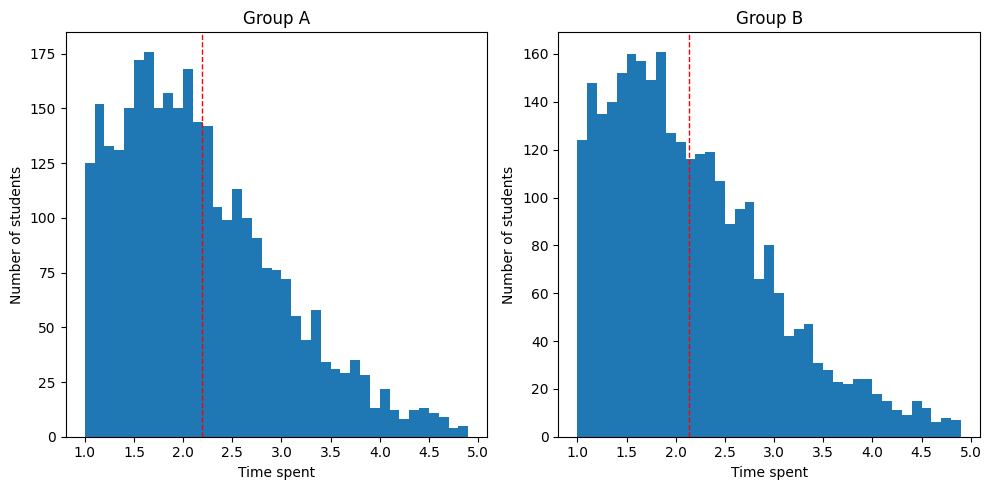

Group A: 2.18730972890087
Group B: 2.1363019299667103
TtestResult(statistic=np.float64(1.471991692833658), pvalue=np.float64(0.1410636211185301), df=np.float64(7770.070763761238))


In [56]:
group_A = ts_df.query(" userGroup== 'A'")["timeSpent_quiz"]
group_B = ts_df.query(" userGroup== 'B'")["timeSpent_quiz"]
fig, axs = plt.subplots(1,2, figsize=(10, 5))
bins = np.arange(1, 5,.1)
group_A.plot(kind="hist", bins=bins, ax=axs[0])
group_B.plot(kind="hist", bins=bins, ax=axs[1])
axs[0].set_title("Group A")
axs[1].set_title("Group B")
axs[0].set_xlabel("Time spent")
axs[1].set_xlabel("Time spent")
axs[0].set_ylabel("Number of students")
axs[1].set_ylabel("Number of students")
#plot averages
axs[0].axvline(group_A.mean(), color='r', linestyle='dashed', linewidth=1)
axs[1].axvline(group_B.mean(), color='r', linestyle='dashed', linewidth=1)
plt.tight_layout()
plt.savefig('figures/quiz/time_spent_groups.png')
plt.show()
print("Group A:", group_A.mean())
print("Group B:", group_B.mean())
print(stats.ttest_ind(group_A,group_B,equal_var=False))




## Explain vs Read (By Quiz)

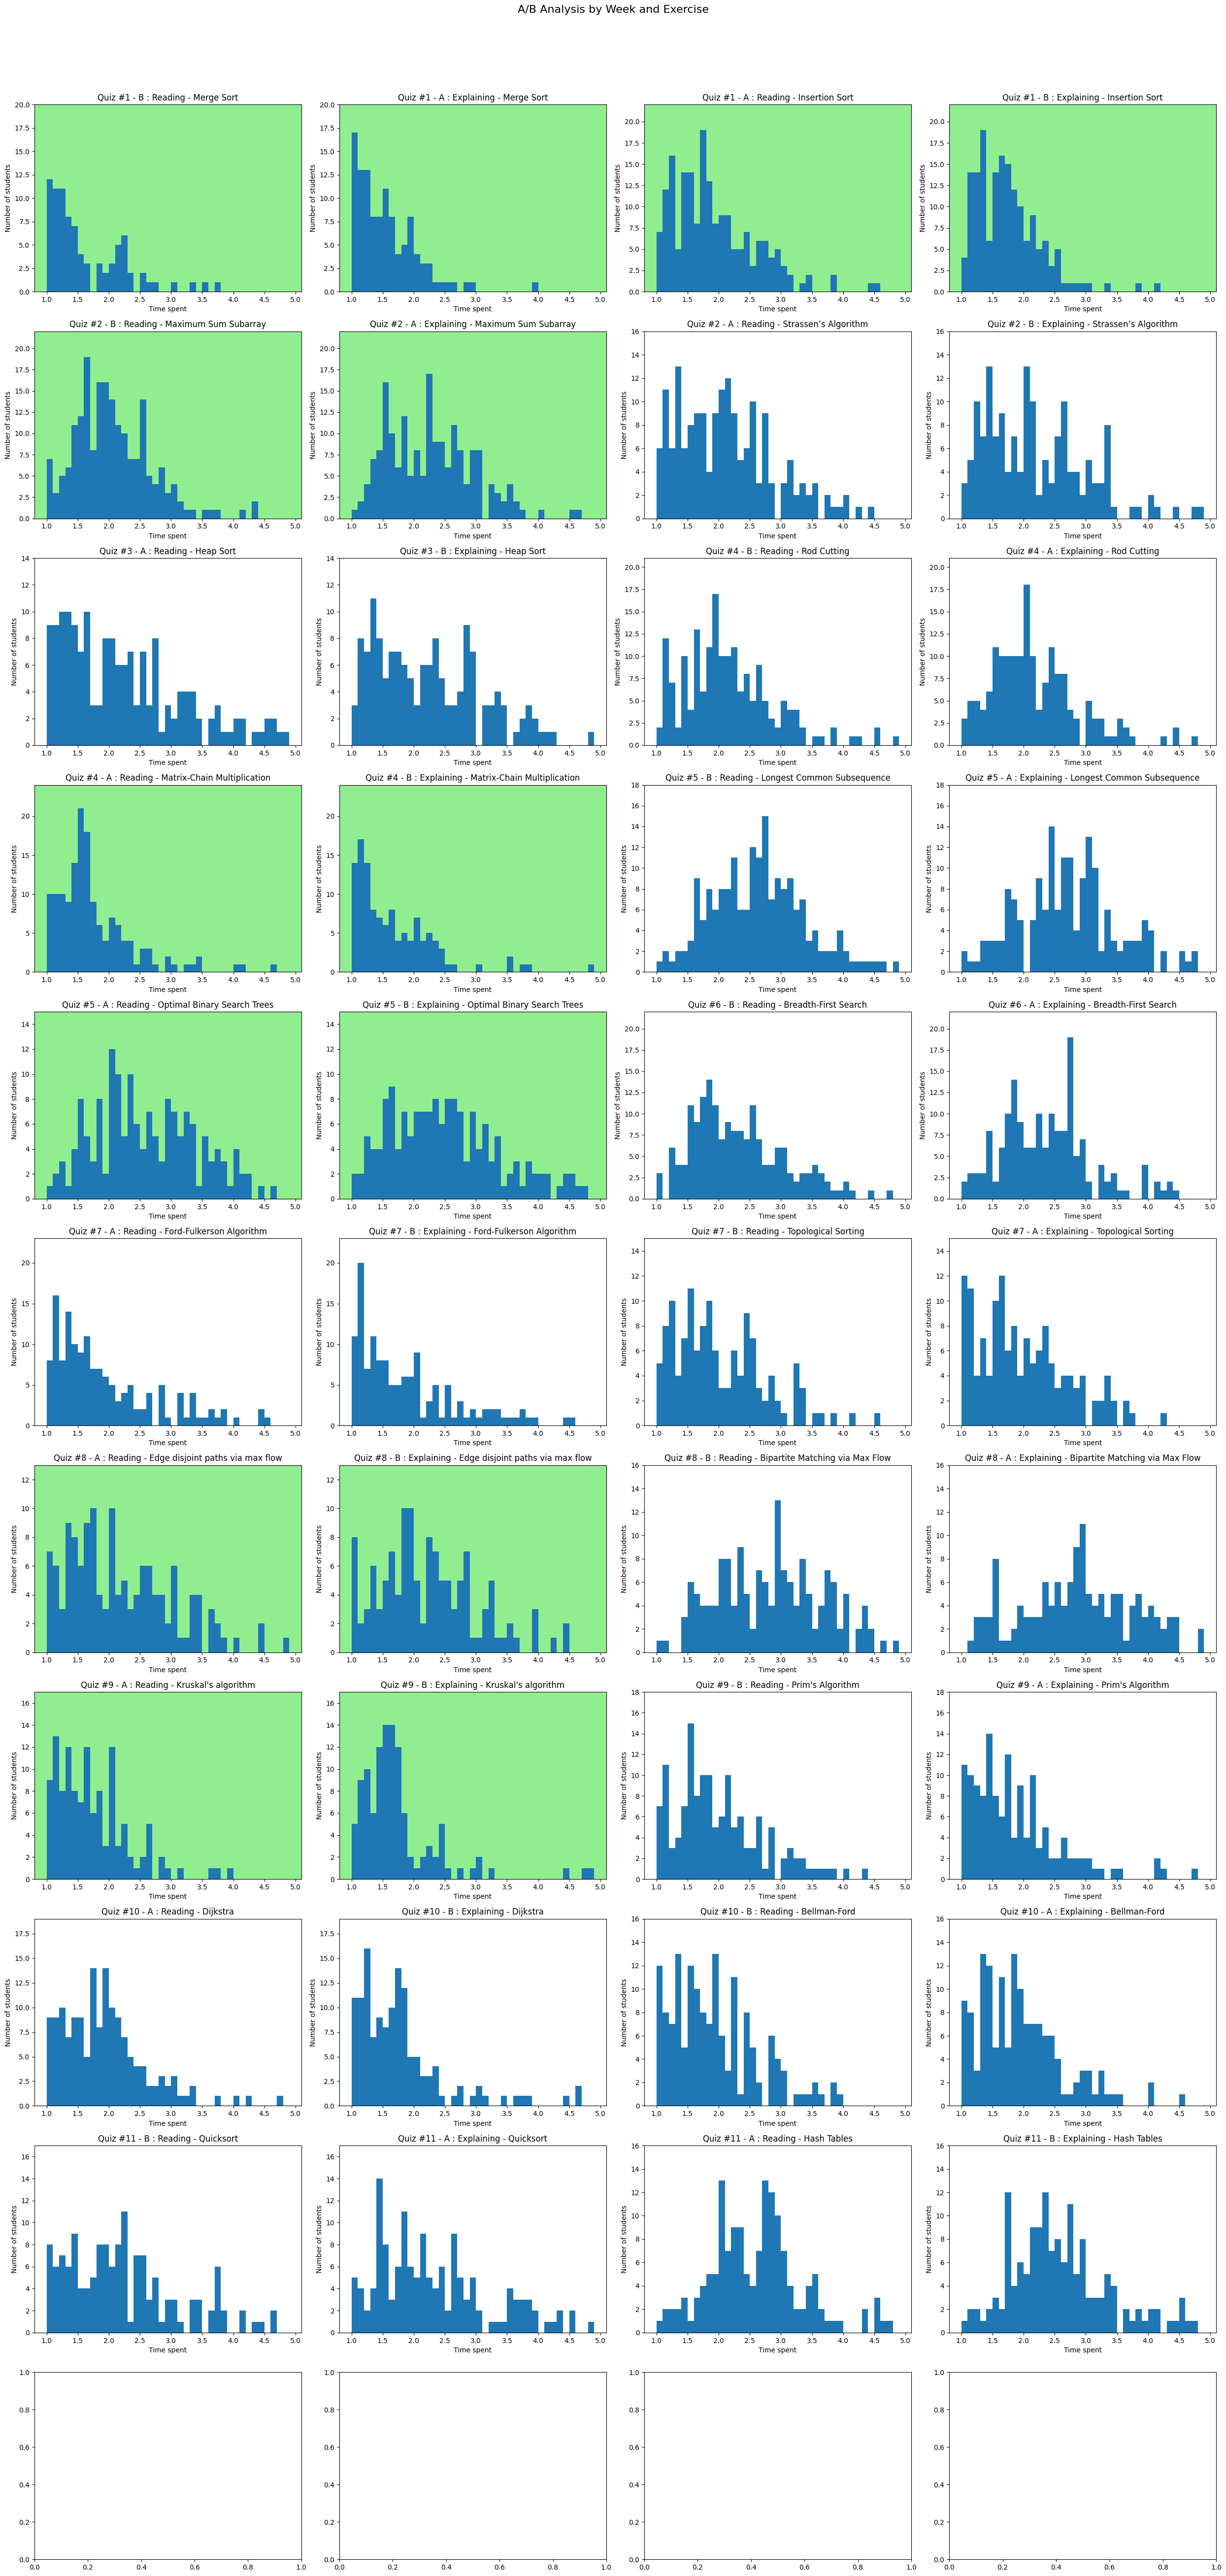

Quiz #1 - Merge Sort - Pvalue : 0.025075124709876363
Explaining : A 
A
count    223.000000
mean       0.936233
std        0.768728
min        0.019066
25%        0.365572
50%        0.767538
75%        1.266618
max        4.971981
Name: timeSpent_quiz, dtype: float64
--------------------
B
count    208.000000
mean       1.089578
std        0.645355
min        0.078754
25%        0.602337
50%        1.045190
75%        1.505071
max        3.915859
Name: timeSpent_quiz, dtype: float64
----------------------------------------
Quiz #1 - Insertion Sort - Pvalue : 0.00028419303654396525
Explaining : B 
A
count    224.000000
mean       2.030941
std        1.367353
min        0.080061
25%        1.255985
50%        1.745300
75%        2.329015
max        8.625284
Name: timeSpent_quiz, dtype: float64
--------------------
B
count    209.000000
mean       1.615988
std        0.969452
min        0.051771
25%        1.158420
50%        1.560387
75%        1.921182
max        8.279812
Name: timeSpen

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Initialize a figure with specified size
fig, axs = plt.subplots(11, 4, figsize=(25, 55))  # 11 rows, 4 columns
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing

stats_arr = []
# Flatten the axes array for easy indexing
axs = axs.flatten()

plot_index = 0  # To track the subplot index
for week in weeks:
    group_a = df[(df["userGroup"] == "A") & (df["week"] == week)].dropna(subset=["timeSpent_quiz"]).drop_duplicates(subset=["userId", "exerciseName"])
    group_b = df[(df["userGroup"] == "B") & (df["week"] == week)].dropna(subset=["timeSpent_quiz"]).drop_duplicates(subset=["userId", "exerciseName"])
    exercise_list = group_a["exerciseName"].unique()
    
    for exo in exercise_list:
        bins = np.arange(1, 5,.1)
        cg = group_a[group_a["exerciseName"] == exo]["controlGroup"].values[0]
        
        if cg == "A":
            index = 0
            axs[plot_index].set_title(f"{week} - A : Reading - {exo}")
            axs[plot_index + 1].set_title(f"{week} - B : Explaining - {exo}")
        else:
            index = 1
            axs[plot_index + 1].set_title(f"{week} - A : Explaining - {exo}")
            axs[plot_index].set_title(f"{week} - B : Reading - {exo}")
        
        # Plot histograms for both groups
        group_a[group_a["exerciseName"] == exo]["timeSpent_quiz"].plot(kind="hist", bins=bins, ax=axs[plot_index])
        group_b[group_b["exerciseName"] == exo]["timeSpent_quiz"].plot(kind="hist", bins=bins, ax=axs[plot_index + 1])
        
        # Set axis labels
        axs[plot_index].set_xlabel("Time spent")
        axs[plot_index + 1].set_xlabel("Time spent")
        axs[plot_index].set_ylabel("Number of students")
        axs[plot_index + 1].set_ylabel("Number of students")

        # Set constant y-axis for comparison
        max_occ1 = pd.cut(group_a[group_a["exerciseName"] == exo]["timeSpent_quiz"], bins=bins).value_counts().max()
        max_occ2 = pd.cut(group_b[group_b["exerciseName"] == exo]["timeSpent_quiz"], bins=bins).value_counts().max()
        max_occ = max(max_occ1, max_occ2)+3
        axs[plot_index].set_ylim([0, max_occ])
        axs[plot_index + 1].set_ylim([0, max_occ])
        
        # Perform t-test
        ttest = stats.ttest_ind(group_a[group_a["exerciseName"] == exo]["timeSpent_quiz"], group_b[group_b["exerciseName"] == exo]["timeSpent_quiz"], equal_var=False)
        stats_arr.append(f"{week} - {exo} - Pvalue : {ttest.pvalue}")
        
        if ttest.pvalue < 0.05:
            axs[plot_index].set_facecolor('lightgreen')
            axs[plot_index + 1].set_facecolor('lightgreen')
            s = "Explaining : B \n" if cg == "A" else "Explaining : A \n" 
            s += "A\n" + str(group_a[group_a["exerciseName"] == exo]["timeSpent_quiz"].describe()) + "\n" + "-"*20 + "\n"
            s += "B\n" + str(group_b[group_b["exerciseName"] == exo]["timeSpent_quiz"].describe())
            stats_arr.append(s)
        
        stats_arr.append("-"*40)
        plot_index += 2  # Move to the next pair of subplots
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("A/B Analysis by Week and Exercise", fontsize=16)
plt.savefig('figures/quiz/time_spent_groups_week.png')
plt.show()


# Print stats
for line in stats_arr:
    print(line)

# Message Time Analysis

## Number of Messages

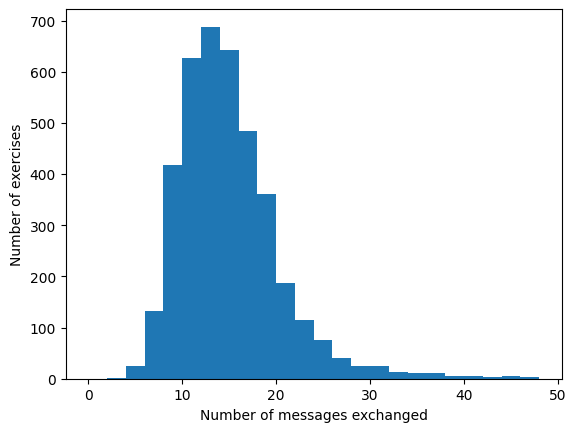

count    3905.000000
mean       15.000000
std         5.465943
min         3.000000
25%        11.000000
50%        15.000000
75%        17.000000
max        49.000000
Name: n_mess, dtype: float64


In [58]:
mess_df = df.drop_duplicates(subset=["userId","exerciseId"]).query("n_mess <50")
mess_df["n_mess"].plot(kind='hist', bins=np.arange(0, 50, 2))
plt.xlabel("Number of messages exchanged")
plt.ylabel("Number of exercises")
plt.savefig('figures/messages/n_mess.png')
plt.show() 
print(mess_df["n_mess"].describe())


### A vs B (Overall)

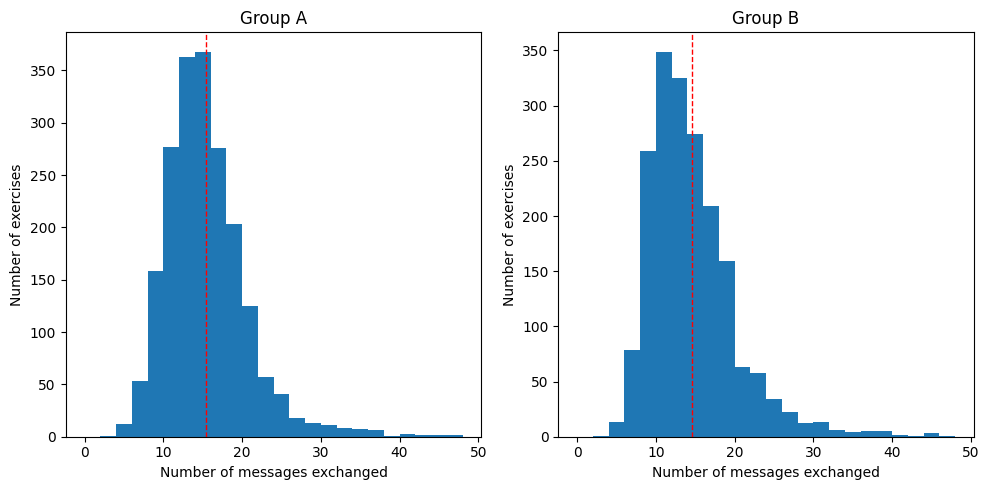

Group A: 15.434977578475337
Group B: 14.54004214963119
TtestResult(statistic=np.float64(5.122295365385269), pvalue=np.float64(3.166123156000449e-07), df=np.float64(3854.9988673652206))


In [59]:
group_A = mess_df.query(" userGroup== 'A'")["n_mess"]
group_B = mess_df.query(" userGroup== 'B'")["n_mess"]
fig, axs = plt.subplots(1,2, figsize=(10, 5))
group_A.plot(kind="hist", bins=np.arange(0,50, 2), ax=axs[0])
group_B.plot(kind="hist", bins=np.arange(0,50, 2), ax=axs[1])
axs[0].set_title("Group A")
axs[1].set_title("Group B")
axs[0].set_xlabel("Number of messages exchanged")
axs[1].set_xlabel("Number of messages exchanged")
axs[0].set_ylabel("Number of exercises")
axs[1].set_ylabel("Number of exercises")
#plot averages
axs[0].axvline(group_A.mean(), color='r', linestyle='dashed', linewidth=1)
axs[1].axvline(group_B.mean(), color='r', linestyle='dashed', linewidth=1)
plt.tight_layout()
plt.savefig('figures/messages/n_mess_groups.png')
plt.show()
print("Group A:", group_A.mean())
print("Group B:", group_B.mean())
print(stats.ttest_ind(group_A,group_B,equal_var=False))


### A vs B (By Week)

Quiz #1 - Pvalue : 0.002135593537531607
Group A
16.308755760368662
Group B
14.536585365853659
----------------------------------------
Quiz #2 - Pvalue : 1.0390513626476244e-18
Group A
14.67605633802817
Group B
11.412060301507537
----------------------------------------
Quiz #4 - Pvalue : 0.5992288543732696
----------------------------------------
Quiz #5 - Pvalue : 0.06577882406807954
----------------------------------------
Quiz #7 - Pvalue : 0.01345868668180145
Group A
14.871657754010695
Group B
16.191011235955056
----------------------------------------
Quiz #8 - Pvalue : 0.13674966570738006
----------------------------------------
Quiz #9 - Pvalue : 0.7560168933307071
----------------------------------------
Quiz #10 - Pvalue : 0.0023479752962248758
Group A
14.02030456852792
Group B
15.656084656084657
----------------------------------------
Quiz #11 - Pvalue : 3.678416073572228e-14
Group A
14.655737704918034
Group B
10.9438202247191
----------------------------------------


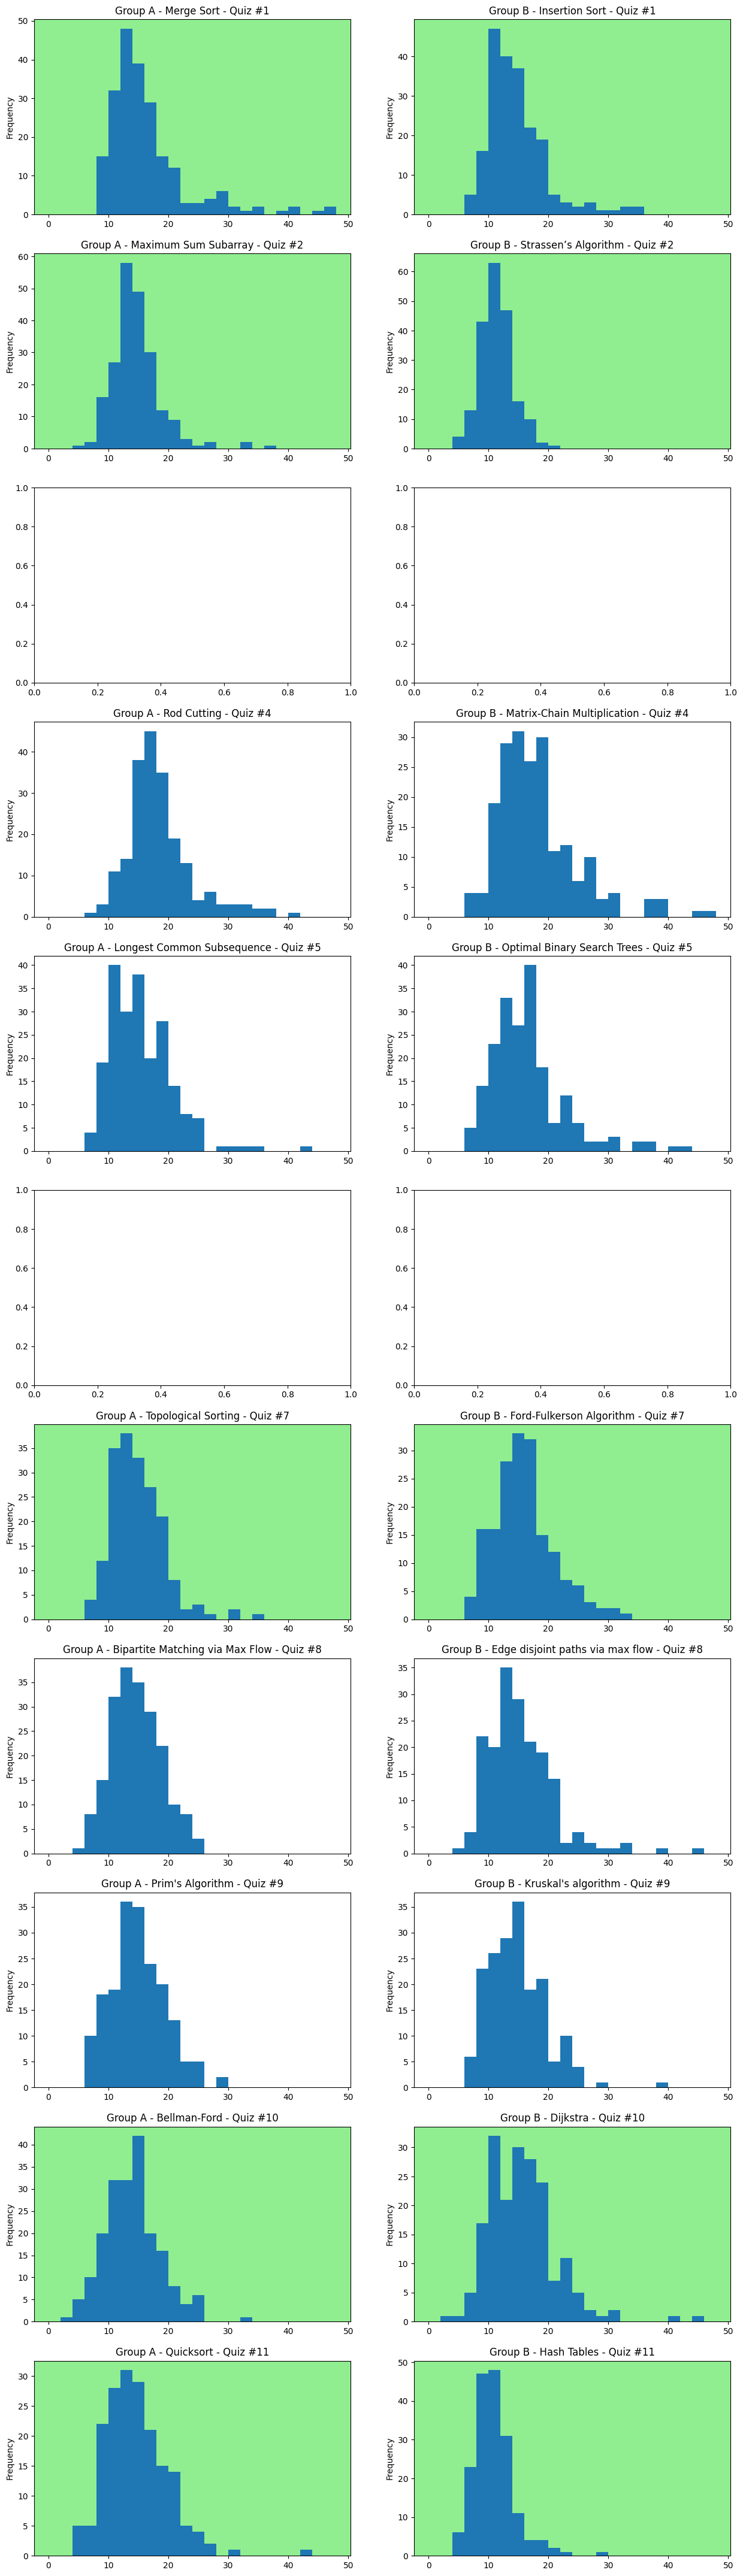

In [60]:
#number of message per week
fig, axs = plt.subplots(len(weeks),2, figsize=(15, 55))
for i,week in enumerate(weeks):
    if week in invalid_weeks:
        continue
    group_a = mess_df[(mess_df["userGroup"] == "A") & (mess_df["week"] == week)]
    group_b = mess_df[(mess_df["userGroup"] == "B") & (mess_df["week"] == week)]
    bins = np.arange(0, 50, 2)
    group_a["n_mess"].plot(kind="hist", bins=bins, ax=axs[i,0])
    group_b["n_mess"].plot(kind="hist", bins=bins, ax=axs[i,1])
    axs[i,0].set_title("Group A - "+group_a["exerciseName"].values[0]+" - "+week)
    axs[i,1].set_title("Group B - "+group_b["exerciseName"].values[0]+" - "+week)
    # plt.suptitle(week)    
    ttest = stats.ttest_ind(group_a["n_mess"], group_b["n_mess"], equal_var=False)
    print(f"{week} - Pvalue : {ttest.pvalue}")
    if ttest.pvalue < 0.05:
        print("Group A")
        print(group_a["n_mess"].mean())
        print("Group B")
        print(group_b["n_mess"].mean())
        axs[i,0].set_facecolor('lightgreen')
        axs[i,1].set_facecolor('lightgreen')
        # # show mean
        # axs[i,0].axvline(group_a["n_mess"].mean(), color='r', linestyle='dashed', linewidth=1)
        # axs[i,1].axvline(group_b["n_mess"].mean(), color='r', linestyle='dashed', linewidth=1)
    print("-"*40)
plt.savefig('figures/messages/n_mess_groups_week.png')
plt.show()


## Time Spent on Messages

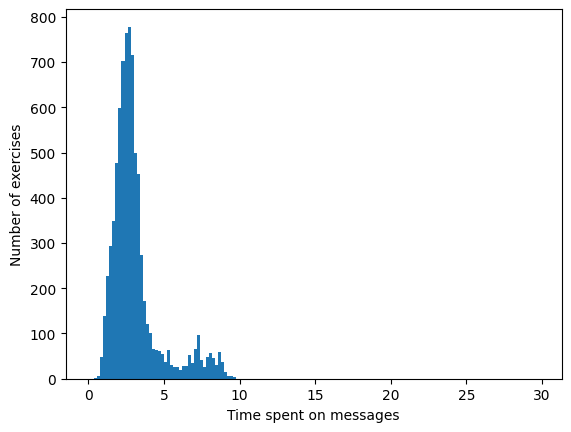

count    7846.000000
mean        3.108726
std         1.675388
min         0.439428
25%         2.143612
50%         2.682566
75%         3.319280
max         9.752590
Name: timeSpent_message, dtype: float64


In [61]:
tsm = df.dropna(subset=["timeSpent_message"]).drop_duplicates(subset=["userId","exerciseId"])
tsm["timeSpent_message"].plot(kind='hist', bins=np.arange(0, 30, .20))
plt.xlabel("Time spent on messages")
plt.ylabel("Number of exercises")
plt.savefig('figures/messages/time_spent.png')
plt.show()
print(tsm["timeSpent_message"].describe())


### A vs B (Overall)

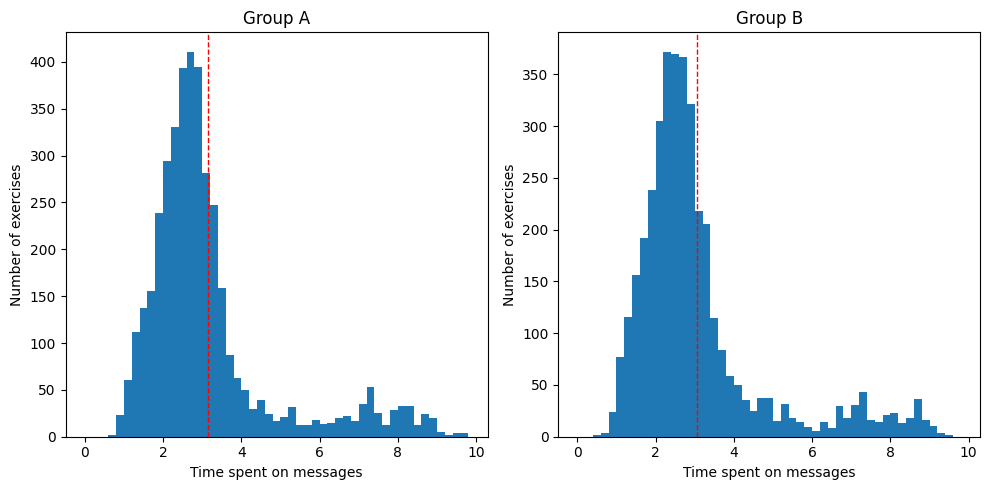

Group A: 3.1553635267325864
Group B: 3.0595736354641194
TtestResult(statistic=np.float64(2.532724315292345), pvalue=np.float64(0.011337361633287107), df=np.float64(7828.361341760695))


In [62]:
group_A = tsm.query("userGroup == 'A'")
group_B = tsm.query("userGroup == 'B'")
fig, axs = plt.subplots(1,2, figsize=(10, 5))
group_A["timeSpent_message"].plot(kind="hist", bins=np.arange(0,10, .2), ax=axs[0])
group_B["timeSpent_message"].plot(kind="hist", bins=np.arange(0,10, .2), ax=axs[1])
axs[0].set_title("Group A")
axs[1].set_title("Group B")
axs[0].set_xlabel("Time spent on messages")
axs[1].set_xlabel("Time spent on messages")
axs[0].set_ylabel("Number of exercises")
axs[1].set_ylabel("Number of exercises")
#plot averages
axs[0].axvline(group_A["timeSpent_message"].mean(), color='r', linestyle='dashed', linewidth=1)
axs[1].axvline(group_B["timeSpent_message"].mean(), color='r', linestyle='dashed', linewidth=1)
plt.tight_layout()
plt.savefig('figures/messages/time_spent_groups.png')
plt.show()
print("Group A:", group_A["timeSpent_message"].mean())
print("Group B:", group_B["timeSpent_message"].mean())
print(stats.ttest_ind(group_A["timeSpent_message"],group_B["timeSpent_message"],equal_var=False))


## A vs B (By Week)

Quiz #1 - Pvalue : 0.03745593486469389
Group A
17.80269058295964
Group B
14.536585365853659
----------------------------------------
Quiz #2 - Pvalue : 0.0008460334442415601
Group A
14.92056074766355
Group B
11.412060301507537
----------------------------------------
Quiz #4 - Pvalue : 0.8875534682040724
----------------------------------------
Quiz #5 - Pvalue : 0.04772770029619111
Group A
15.738317757009346
Group B
16.522842639593907
----------------------------------------
Quiz #7 - Pvalue : 0.6188566296972937
----------------------------------------
Quiz #8 - Pvalue : 0.21524989033010414
----------------------------------------
Quiz #9 - Pvalue : 0.8663628480766166
----------------------------------------
Quiz #10 - Pvalue : 0.6516785077782408
----------------------------------------
Quiz #11 - Pvalue : 0.0037130940803438497
Group A
14.655737704918034
Group B
10.9438202247191
----------------------------------------


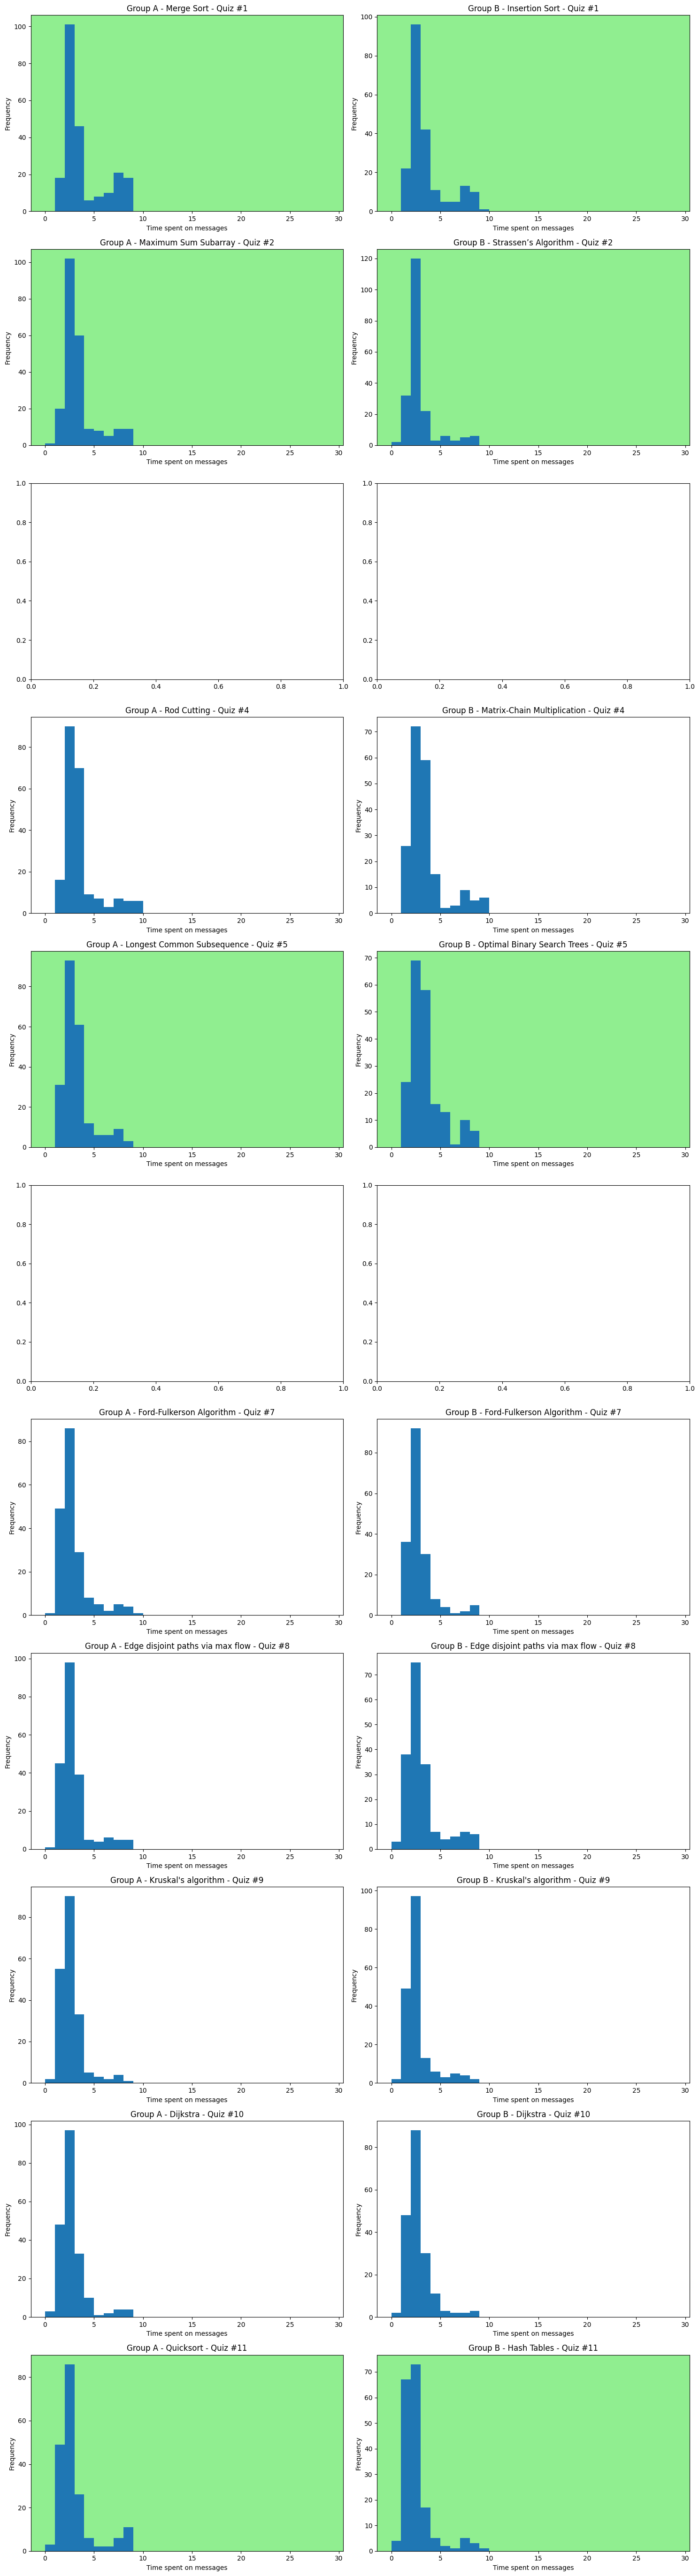

In [63]:
#number of message per week
fig, axs = plt.subplots(len(weeks),2, figsize=(15, 55))
for i,week in enumerate(weeks):
    if week in invalid_weeks:
        continue

    group_a = tsm[(tsm["userGroup"] == "A") & (tsm["week"] == week)]
    group_b = tsm[(mess_df["userGroup"] == "B") & (tsm["week"] == week)]
    bins = np.arange(0, 30, 1)
    group_a["timeSpent_message"].drop_duplicates().plot(kind="hist", bins=bins, ax=axs[i,0])
    group_b["timeSpent_message"].drop_duplicates().plot(kind="hist", bins=bins, ax=axs[i,1])
    axs[i,0].set_title("Group A - "+group_a["exerciseName"].values[0]+" - "+week)
    axs[i,1].set_title("Group B - "+group_b["exerciseName"].values[0]+" - "+week)
    axs[i,0].set_xlabel("Time spent on messages")
    axs[i,1].set_xlabel("Time spent on messages")
    # plt.suptitle(week)    
    ttest = stats.ttest_ind(group_a["timeSpent_message"], group_b["timeSpent_message"], equal_var=False)
    print(f"{week} - Pvalue : {ttest.pvalue}")
    if ttest.pvalue < 0.05:
        print("Group A")
        print(group_a["n_mess"].mean())
        print("Group B")
        print(group_b["n_mess"].mean())
        axs[i,0].set_facecolor('lightgreen')
        axs[i,1].set_facecolor('lightgreen')
        # # show mean
        # axs[i,0].axvline(group_a["n_mess"].mean(), color='r', linestyle='dashed', linewidth=1)
        # axs[i,1].axvline(group_b["n_mess"].mean(), color='r', linestyle='dashed', linewidth=1)
    print("-"*40)
plt.savefig('figures/messages/timeSpent_message_groups_week.png')
plt.tight_layout()
plt.show()


# Reading Time Analysis

<Axes: ylabel='Frequency'>

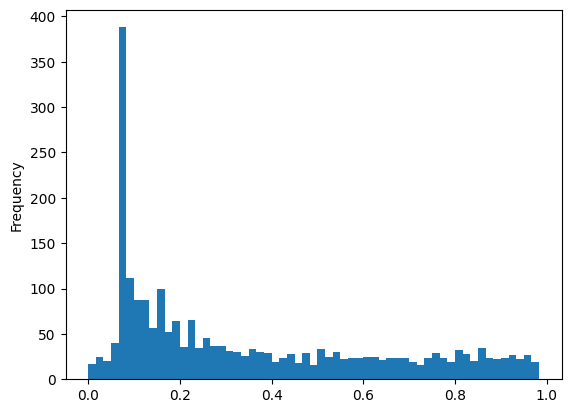

In [64]:
reading = df.query("variant == 'reading'").drop_duplicates(subset=["userId", "exerciseName"])
reading["timeSpent_read"].plot(kind='hist', bins=np.arange(0, 1, 
                                                           1/60))

# Message / Quiz Time Analysis

In [65]:
mq = df.dropna(subset=["timeSpent_quiz","timeSpent_message"]).drop_duplicates(subset=["userId","exerciseId"]).query("variant == 'explain'")
mq[["timeSpent_quiz","timeSpent_message"]].describe()

,timeSpent_quiz,timeSpent_message
count,3888.000000,3888.000000
mean,2.058834,3.116682
std,1.431408,1.689467
min,0.019066,0.439428
25%,1.161552,2.138358
50%,1.815148,2.676205
75%,2.564106,3.324810
max,9.456740,9.752590


In [66]:
print(mq[["timeSpent_quiz","timeSpent_message"]].corr())

                   timeSpent_quiz  timeSpent_message
timeSpent_quiz           1.000000           0.007588
timeSpent_message        0.007588           1.000000


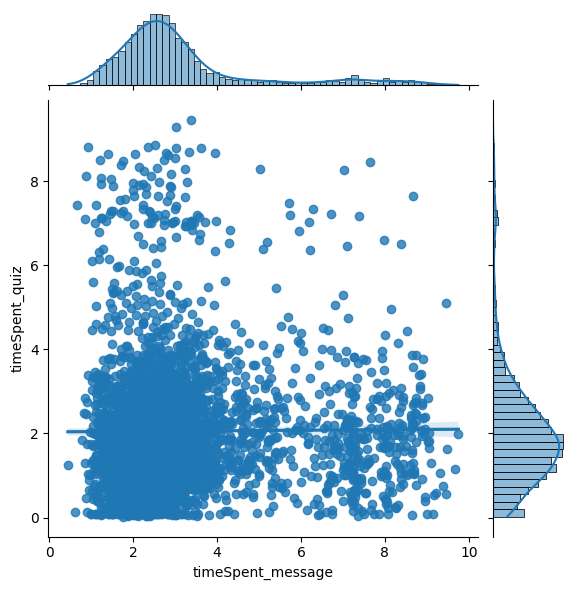

In [67]:
sns.jointplot(data=mq, y="timeSpent_quiz", x="timeSpent_message", kind="reg")

In [68]:
bins = np.arange(0, 35, 5)
mq["bin_avg"] = pd.cut(mq["timeSpent_message"], bins=bins)
display(mq)
display(mq.groupby("bin_avg")["timeSpent_quiz"].mean())

,_creationTime,_id,attemptId,exerciseId,type,userId,variant,details,version,systemMessageId,...,n_mess,timeSpent_message,userData,userGrades,valid,timeSpent_read,content,content_usr,num_attempts,bin_avg
1,2024-04-16 08:00:01.116,k57000a4rv5wgy13d63pqyt51s6qb2vv,j57adjsev6qjazakv9p4ad7qwh6qany3,k1710bmgh2mwgaqv7sjkmmfh1x6pveqf,quizSubmission,js7ese808vctnr15sy1te2pvx96mndmx,explain,"{'answers': [2.0, 0.0, 2.0], 'correctness': 1....",2.0,None,...,11.0,2.840592,"{'gender': 'Male', 'section': 'SC', 'semester'...","{'coding': 100.0, 'midterm': 63, 'final': 72, ...",True,1.186817,None,None,9.0,"(0, 5]"
3,2024-04-18 08:10:36.998,k57000m99awdk4jw41cjfe4jkn6qf1jj,j572w733907q5k2w0kkk4a19z96qfaec,k171kqa60g6a9qpm0f0jv07wn16ptnr1,quizSubmission,js7e56b2v2t5nacr7e4n8dnn3d6mb606,explain,"{'answers': [0.0, 1.0, 1.0], 'correctness': 0....",2.0,None,...,13.0,2.661302,"{'gender': 'Female', 'section': 'ING_MATH', 's...","{'coding': 100.0, 'midterm': 82, 'final': 81, ...",True,1.055467,None,None,53.0,"(0, 5]"
4,2024-03-13 16:35:30.072,k57000mdpmrfm67q4eymvsbqns6n6ezf,j571e3e401tqj2mag6mjgrcynx6n7t96,k1715d99fyvzt35jfm2638g3nd6n35z3,exerciseCompleted,js7534h7gnm8pmyem0n6ttdb816mb94w,explain,None,NaN,None,...,9.0,1.437085,"{'gender': 'Male', 'section': 'SC', 'semester'...","{'coding': 100.0, 'midterm': 87, 'final': 68, ...",True,0.766223,None,None,NaN,"(0, 5]"
5,2024-03-28 16:24:01.600,k57000ny7w4g28vjeeyb9x8se16p55f9,j578ec52hh90fvkmk132x6ege96p45ba,k17asvnfeyp3q949hdkwjq2and6p2x6e,answerGenerated,js7984yjpe01cj1761gygtt3dx6mafdh,explain,None,NaN,jd7b55hm5qjm0196n9rt6jyh7n6p581t,...,15.0,3.248727,"{'gender': 'Male', 'section': 'IN', 'semester'...","{'coding': 85.0, 'midterm': 100, 'final': 71, ...",True,0.268879,"I see that you've provided a formula. However,...","M[i,j]=min i≤k<j (M[i,k]+M[k+1,j]+p i−1×p k×p )j",NaN,"(0, 5]"
7,2024-05-22 09:03:11.012,k57000tdp2bnpcsszr3m7nyr316sjeg0,j577f039a412vmwetm03yv6np16sj2t3,k17416m11n2qpqy5sr2zz6782s6s2y2n,attemptStarted,js770gtc71hjt59gn0n6xmx9an6mb4tq,explain,None,NaN,None,...,31.0,8.521140,"{'gender': 'Male', 'section': 'MA', 'semester'...","{'coding': 100.0, 'midterm': 78, 'final': 92, ...",True,0.084200,None,None,NaN,"(5, 10]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41564,2024-03-03 17:57:34.920,k574cbhc14qpds5vvgbzzwhar16mja7g,j57193v69gwd5d96kw0rfc9s6h6mkx40,k17dh8h1cdvfn45j3527z3w2d96m8zk6,feedbackGiven,js73zd9ts5drk3bf0qxqhb32a96me9y6,explain,None,NaN,jd7c8vm606p3c28vk3e21j4mtd6mkyay,...,11.0,3.368711,"{'gender': 'Male', 'section': 'SC', 'semester'...","{'coding': 100.0, 'midterm': 54, 'final': 68, ...",True,0.927947,You have explained the Merge Sort algorithm co...,None,NaN,"(0, 5]"
43341,2024-05-20 10:28:16.649,k574j96b0m3y9rdy7hhtjpy64d6se7mk,j5732za9bc5znn2cfrx8t043h16sf2hz,k176kkt806khrpxnctb9hczm316rtsrq,messageSent,js74pf2m8e8jrz2gg9s1hep35s6mfngw,explain,None,NaN,jd7bytbw10r467t0zsn760ptmd6sf7bp,...,11.0,1.277294,"{'gender': 'Female', 'section': 'SC_DS', 'seme...","{'coding': 100.0, 'midterm': 81, 'final': 52, ...",True,0.154576,"Okay, got it. Now, when does the algorithm kno...",t simply skips that node and moves on to the n...,NaN,"(0, 5]"
48423,2024-03-03 13:14:30.634,k57531qmyef238nwft2sbqxyc16mkvdk,j57dfp1wann33m1kwv4bg0v2xs6mj32b,k17dh8h1cdvfn45j3527z3w2d96m8zk6,answerGenerated,js749jccx4w28s4kqv3rnahw6x6meyf2,explain,None,NaN,jd7cnak40y9med1kwkr9s6w3f16mk7b7,...,13.0,3.211669,"{'gender': 'Male', 'section': 'SC', 'semester'...","{'coding': 85.0, 'midterm': 60, 'final': 66, '...",True,8.181192,I see. So the merging process works by compari...,Taking back my example from the dividing phase...,NaN,"(0, 5]"
53606,2024-04-22 12:00:41.164,k575n08ywqcbr1j6jxkjh4b2z16qpzgx,j570q1k98yqbd9qrnahtavecvd6qqw0b,k171kqa60g6a9qpm0f0jv07wn16ptnr1,answerGenerated,js7f8kdtkjrmqxxvz26gsykw7h6mbzmv,explain,None,NaN,jd7a9mwzy15sf7x21m9ey21vcx6qq2pa,...,15.0,2.651220,"{'gender': 'Male', 'section': 'SC', 'semester'...","{'coding': 100.0, 'midterm': 58, 'fina

bin_avg
(0, 5]      2.055533
(5, 10]     2.084055
(10, 15]         NaN
(15, 20]         NaN
(20, 25]         NaN
(25, 30]         NaN
Name: timeSpent_quiz, dtype: float64

## Grade Analysis

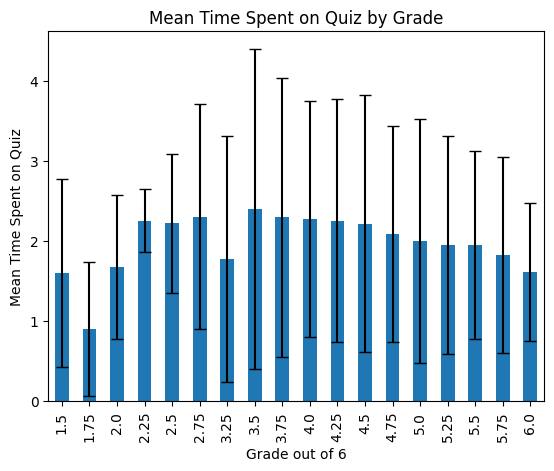

In [69]:
# Calculate mean and standard deviation
mean_time_spent = mq.groupby(mq["userGrades"].dropna().apply(lambda x: x.get("grade_out_of_6")))["timeSpent_quiz"].mean()
std_time_spent = mq.groupby(mq["userGrades"].dropna().apply(lambda x: x.get("grade_out_of_6")))["timeSpent_quiz"].std()

# Plot with error bars
mean_time_spent.plot(kind='bar', yerr=std_time_spent, capsize=4)
plt.xlabel('Grade out of 6')
plt.ylabel('Mean Time Spent on Quiz')
plt.title('Mean Time Spent on Quiz by Grade')
plt.show()

count    448.000000
mean       2.148824
std        0.556250
min        0.845822
25%        1.766791
50%        2.072243
75%        2.472693
max        4.930202
Name: avg_time_quiz, dtype: float64

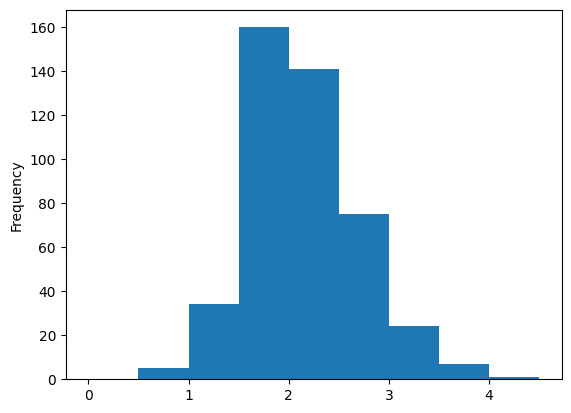

In [70]:
dfavg = df.copy()
dfavg["avg_time_quiz"]  = dfavg.dropna(subset=["timeSpent_quiz"]).drop_duplicates(subset=["userId","exerciseId"]).groupby(["userId"])["timeSpent_quiz"].transform('mean')
dfavg.drop_duplicates(subset="userId")["avg_time_quiz"].plot(kind='hist', bins=np.arange(0, 5, .5))
dfavg.drop_duplicates(subset="userId")["avg_time_quiz"].describe()

In [71]:
grade_ana = df.copy()

In [72]:
grade_ana["grade"] = grade_ana["userGrades"].apply(lambda x: x.get("grade_out_of_6") if x is not None else None)
grade_ana["grade"].describe()
grade_ana["grade_group"] = pd.cut(grade_ana["grade"], bins=[0, 4, 5, 6], labels=["Low", "Medium", "High"])

In [73]:
print(grade_ana.drop_duplicates("userId")["grade_group"].value_counts())

grade_group
Medium    225
High      141
Low        90
Name: count, dtype: int64


Quiz #1 - Merge Sort - Low - r : 1.2360619584861408 - e : 0.9848180148242125 - 0.16197452950036673
Quiz #1 - Merge Sort - Medium - r : 1.0877241408141165 - e : 0.9116227575789967 - 0.05526839207164484
Quiz #1 - Merge Sort - High - r : 1.0010391390521352 - e : 0.9466945154461056 - 0.6549607729391517
Quiz #1 - Merge Sort - 431
Quiz #1 - Insertion Sort - Low - r : 1.9922907845063604 - e : 1.3579043600240788 - 0.014077192759129645
Quiz #1 - Insertion Sort - Medium - r : 2.1959970502256474 - e : 1.723821211559969 - 0.01226655881188581
Quiz #1 - Insertion Sort - High - r : 1.8011424975693089 - e : 1.602275071931345 - 0.16036795449070643
Quiz #1 - Insertion Sort - 433
Quiz #2 - Maximum Sum Subarray - Low - r : 2.719035750429255 - e : 2.33287500456463 - 0.20500236180519363
Quiz #2 - Maximum Sum Subarray - Medium - r : 2.6017785707727024 - e : 2.155415763350377 - 0.00791200970578909
Quiz #2 - Maximum Sum Subarray - High - r : 1.9856988967441769 - e : 1.9989795525004403 - 0.9254343892848799
Quiz

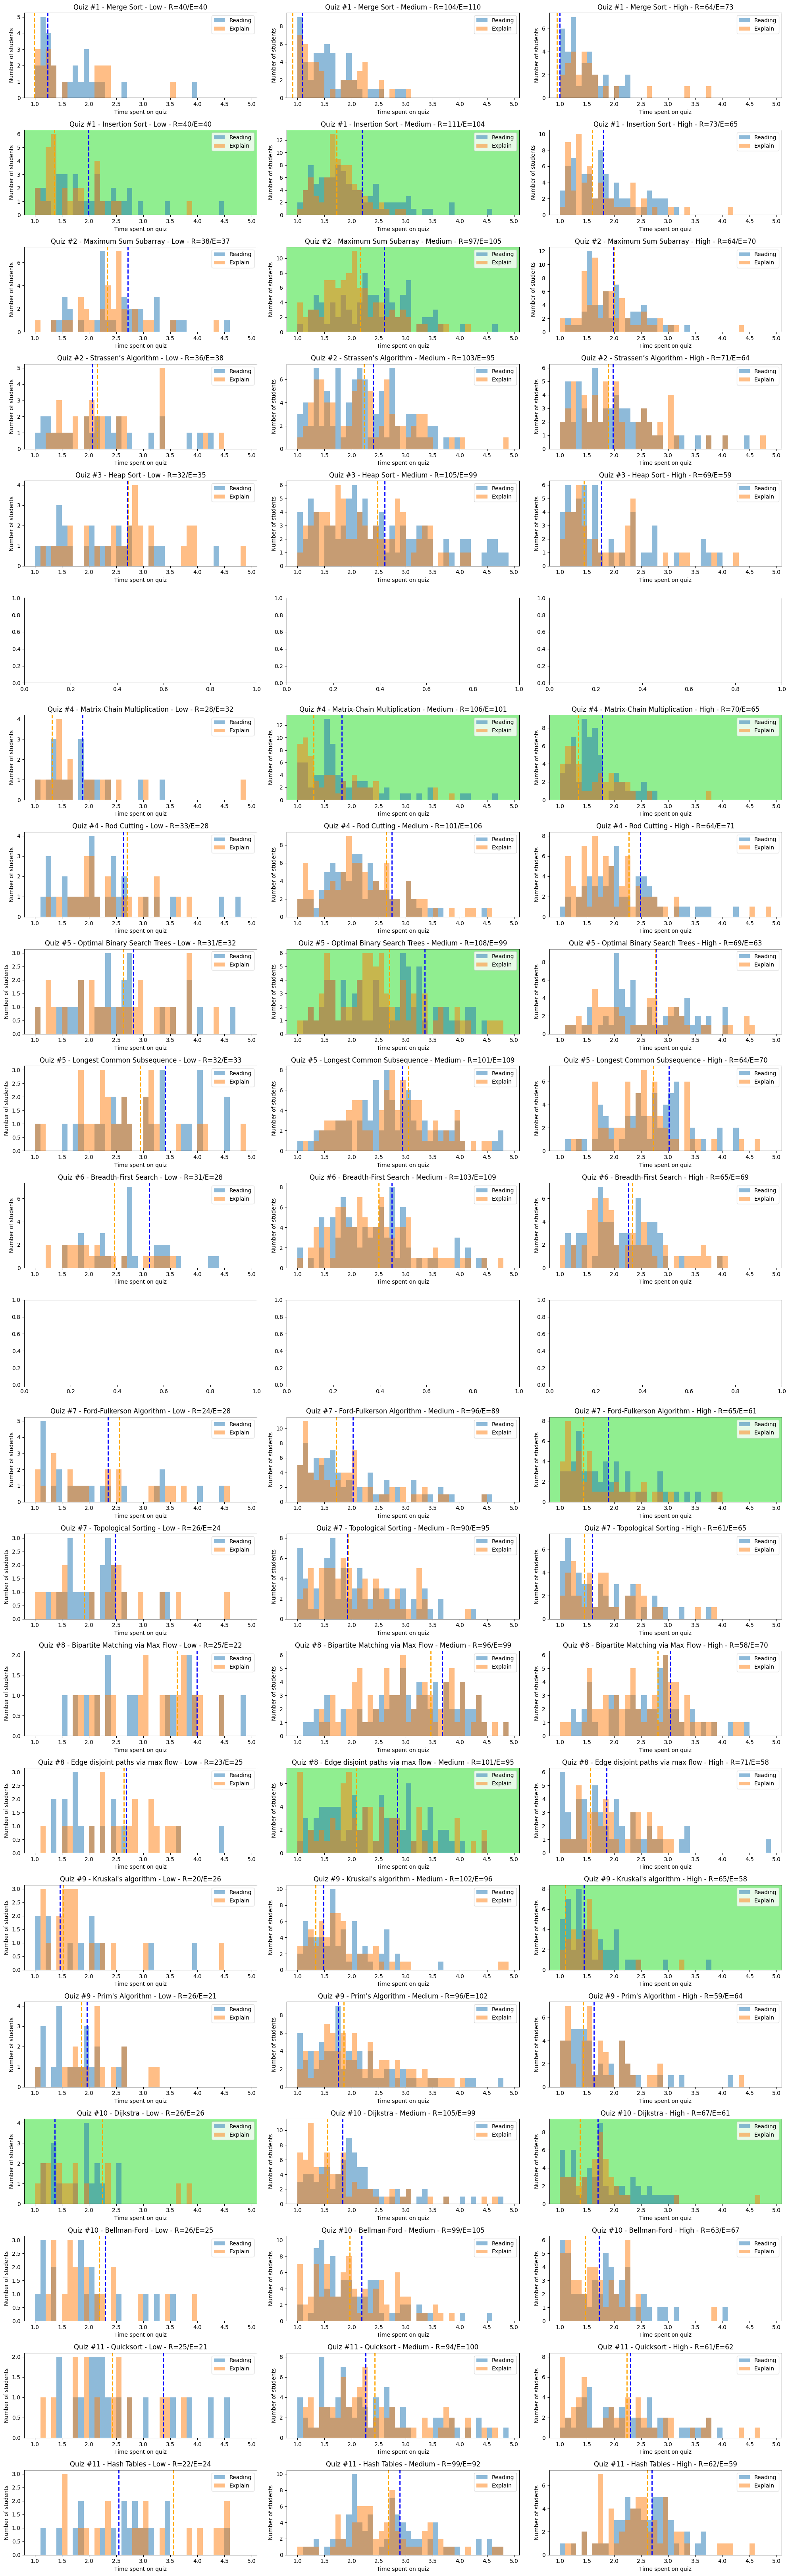

In [74]:
fig, axs = plt.subplots(22,3, figsize=(20, 65))
gg = ["Low", "Medium", "High"]
for i,week in enumerate(weeks):
    for j,ex in enumerate(grade_ana.query("week==@week")["exerciseName"].unique()):
        tot = 0
        for k,group in enumerate(gg):
            read = grade_ana.query("variant == 'reading' and week == @week and exerciseName == @ex and grade_group == @group").dropna(subset=["timeSpent_quiz"]).drop_duplicates(subset=["userId"])["timeSpent_quiz"]
            explain = grade_ana.query("variant == 'explain' and week == @week and exerciseName == @ex and grade_group == @group").dropna(subset=["timeSpent_quiz"]).drop_duplicates(subset=["userId"])["timeSpent_quiz"]
            bins = np.arange(1, 5,.1)
            read.plot(kind="hist", bins=bins, ax=axs[2*i+j,k],alpha=0.5, label="Reading")
            explain.plot(kind="hist", bins=bins, ax=axs[2*i+j,k],alpha=0.5, label="Explain")
            axs[2*i+j,k].set_title(f"{week} - {ex} - {group} - R={len(read)}/E={len(explain)}")
            ttest = stats.ttest_ind(read, explain, equal_var=False)
            axs[2*i+j,k].axvline(read.mean(), color='blue', linestyle='dashed', linewidth=2)
            axs[2*i+j,k].axvline(explain.mean(), color='orange', linestyle='dashed', linewidth=2)
            test = stats.ttest_ind(read,explain,equal_var=False)
            axs[2*i+j,k].set_xlabel("Time spent on quiz")
            axs[2*i+j,k].set_ylabel("Number of students")
            axs[2*i+j,k].legend()
            if test.pvalue < 0.05:
                axs[2*i+j,k].set_facecolor('lightgreen')
            tot += len(read)+len(explain)
            print(f"{week} - {ex} - {group} - r : {read.mean()} - e : {explain.mean()} - {test.pvalue}")
        print(f"{week} - {ex} - {tot}")
plt.legend()
plt.tight_layout(
)
plt.show()


Low: Reading mean: 2.44, Explaining mean: 2.25, p-value: 0.06
Medium: Reading mean: 2.37, Explaining mean: 2.14, p-value: 0.00
High: Reading mean: 2.03, Explaining mean: 1.85, p-value: 0.00


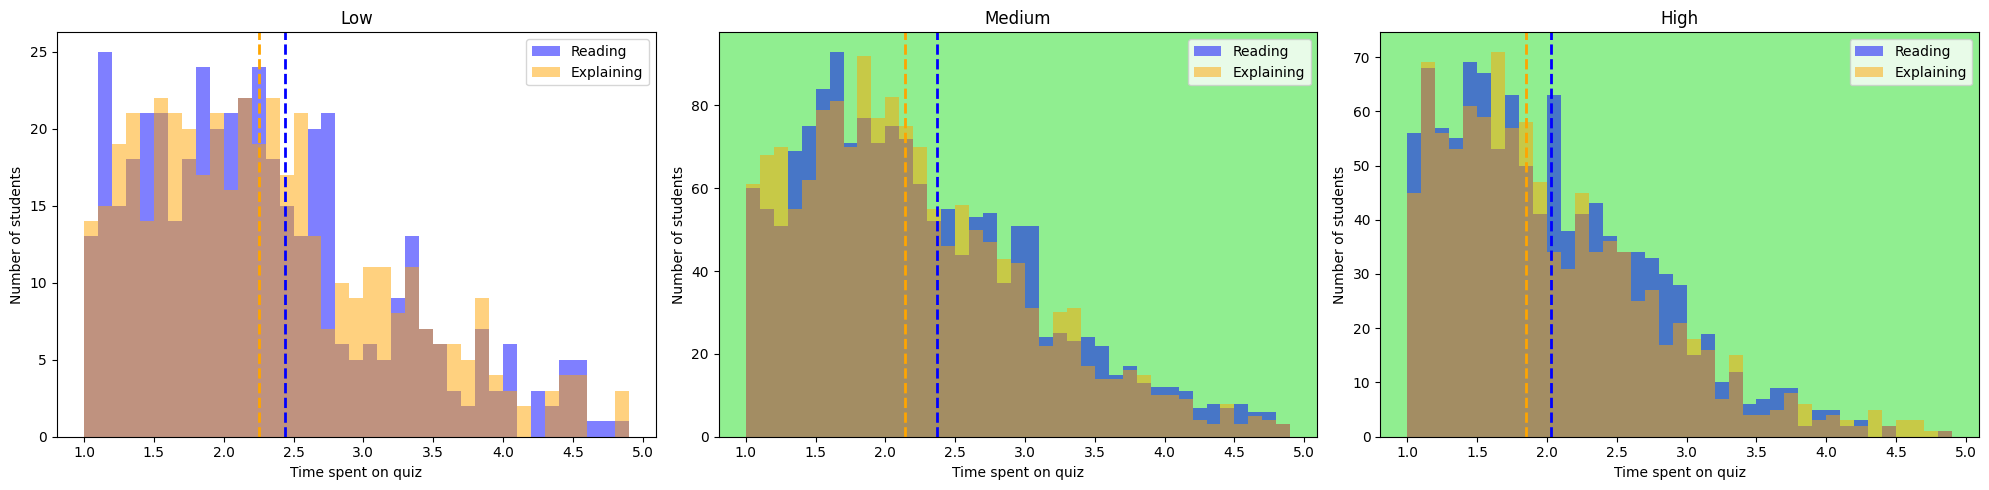

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
bins = np.arange(1, 5,.1)
for i,group in enumerate(gg):
    read = grade_ana.query("variant == 'reading' and grade_group == @group").dropna(subset=["timeSpent_quiz"]).drop_duplicates(subset=["userId","exerciseName"])["timeSpent_quiz"]
    explain = grade_ana.query("variant == 'explain' and grade_group == @group").dropna(subset=["timeSpent_quiz"]).drop_duplicates(subset=["userId","exerciseName"])["timeSpent_quiz"]
    read.plot(kind='hist', bins=bins, ax=ax[i], alpha=0.5, label='Reading', color='blue')
    explain.plot(kind='hist', bins=bins, ax=ax[i], alpha=0.5, label='Explaining', color='orange')
    ax[i].set_xlabel("Time spent on quiz")
    ax[i].set_ylabel("Number of students")
    ax[i].set_title(group)
    ax[i].axvline(read.mean(), color='blue', linestyle='dashed', linewidth=2)
    ax[i].axvline(explain.mean(), color='orange', linestyle='dashed', linewidth=2)
    ttest = stats.ttest_ind(read, explain)
    if ttest.pvalue < 0.05:
        ax[i].set_facecolor('lightgreen')
    print(f"{group}: Reading mean: {read.mean():.2f}, Explaining mean: {explain.mean():.2f}, p-value: {ttest.pvalue:.2f}")
    ax[i].legend()
plt.tight_layout()
plt.savefig('figures/quiz/time_spent_groups_overlay.png')
plt.show()

Low: Reading mean: 2.34, Explaining mean: 2.23, p-value: 0.39820553826369365
Medium: Reading mean: 2.33, Explaining mean: 2.11, p-value: 0.0004930271145156693
High: Reading mean: 2.02, Explaining mean: 1.85, p-value: 0.004343227442724007


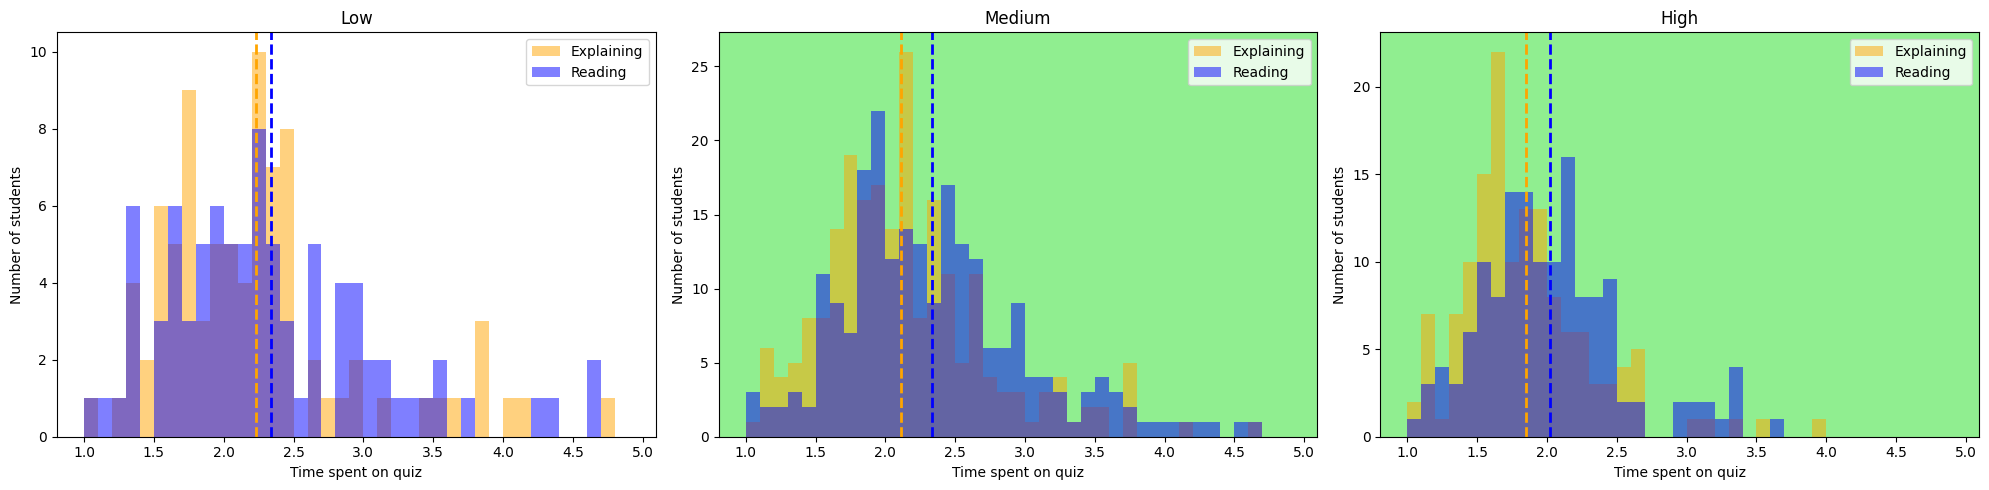

In [76]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
bins = np.arange(1, 5,.1)
for i,group in enumerate(gg):
    read = (grade_ana
            .query("variant == 'reading' and grade_group == @group")  # Step 1: Filter the data
            .drop_duplicates(subset=["userId", "exerciseName"]).dropna(subset=["timeSpent_quiz"])        # Step 2: Drop duplicates
            .groupby("userId", as_index=False)                         # Step 3: Group by userId
            ["timeSpent_quiz"].mean().drop_duplicates("userId")["timeSpent_quiz"])        # Step 4: Calculate mean time spent on quiz)     
    explain = (grade_ana
            .query("variant == 'explain' and grade_group == @group")  # Step 1: Filter the data
            .drop_duplicates(subset=["userId", "exerciseName"]).dropna(subset=["timeSpent_quiz"])        # Step 2: Drop duplicates
            .groupby("userId", as_index=False)                         # Step 3: Group by userId
            ["timeSpent_quiz"].mean().drop_duplicates("userId")["timeSpent_quiz"])     
    explain.plot(kind='hist', bins=bins, ax=ax[i], alpha=0.5, label='Explaining', color='orange')
    read.plot(kind='hist', bins=bins, ax=ax[i], alpha=0.5, label='Reading', color='blue')
    ax[i].set_xlabel("Time spent on quiz")
    ax[i].set_ylabel("Number of students")
    ax[i].set_title(group)
    ax[i].axvline(read.mean(), color='blue', linestyle='dashed', linewidth=2)
    ax[i].axvline(explain.mean(), color='orange', linestyle='dashed', linewidth=2)
    ttest = stats.ttest_ind(read, explain)
    if ttest.pvalue < 0.05:
        ax[i].set_facecolor('lightgreen')
    print(f"{group}: Reading mean: {read.mean():.2f}, Explaining mean: {explain.mean():.2f}, p-value: {ttest.pvalue}")
    ax[i].legend()
plt.tight_layout()
plt.savefig('figures/quiz/time_spent_groups_overlay.png')
plt.show()

In [77]:
feedback = pd.read_json('feedback.jsonl', lines=True)

In [78]:
feedback_ids = feedback["userId"].unique()
print(f"Number of unique users in feedback: {len(feedback_ids)}")

Number of unique users in feedback: 175


In [79]:
grade_fb = grade_ana.query("userId in @feedback_ids").drop_duplicates(subset="userId")["grade"]
grade_nofb = grade_ana.query("userId not in @feedback_ids").drop_duplicates(subset="userId")["grade"]
print("Average grade with feedback:", grade_fb.mean())
print("Average grade without feedback:", grade_nofb.mean())
print(stats.ttest_ind(grade_fb, grade_nofb,equal_var=False))

Average grade with feedback: 4.912337662337662
Average grade without feedback: 4.576158940397351
TtestResult(statistic=np.float64(4.482653493885416), pvalue=np.float64(9.742645905791132e-06), df=np.float64(384.38988683067083))


In [80]:
ts_fb = grade_ana.query("userId in @feedback_ids").dropna(subset="timeSpent_quiz").drop_duplicates(subset="userId")["timeSpent_quiz"]
ts_nfb = grade_ana.query("userId not in @feedback_ids").dropna(subset="timeSpent_quiz").drop_duplicates(subset="userId")["timeSpent_quiz"]
print("Average time spent on quiz of users who gave feedback:", ts_fb.mean())
print("Average time spent on quiz of users who did not give feedback:", ts_nfb.mean())
print(stats.ttest_ind(ts_fb, ts_nfb, equal_var=False))

Average time spent on quiz of users who gave feedback: 2.278052437207551
Average time spent on quiz of users who did not give feedback: 2.443270523519435
TtestResult(statistic=np.float64(-1.0101209066063443), pvalue=np.float64(0.31312934730435876), df=np.float64(352.9475689825775))


In [81]:
ts_fb

0       1.018643
3       6.570499
5       7.032846
11      1.523251
13      0.984458
          ...   
1934    1.335445
2056    0.884381
2064    2.086702
2168    1.403654
3586    2.206740
Name: timeSpent_quiz, Length: 154, dtype: float64